# Newton–Raphson - Fisher scoring methods - steepest ascent  Quasi-Newton optimization with the Hessian approximation update

## Problem:
There were 46 crude oil spills of at least 1000 barrels from tankers in U.S. waters during 1974–1999.The website for this book contains the following data: the number of spills in the ith year, $N_i$; the estimated amount of oil shipped through US waters as part of US import/export operations in the ith year, adjusted for spillage in international or foreignwaters, $b_{i1}$;and the amount of oil shipped through U.S. waters during domestic shipments in the ith year, $b_{i2}$. The data are adapted from [11]. Oil shipment amounts are measured in billions of barrels (Bbbl). 
The volume of oil shipped is a measure of exposure to spill risk. Suppose we use the Poisson process assumption given by $N_i|b_{i1},b_{i2} ∼Poisson(λ_i)$ where $\lambda_i = \alpha_1b_{i1}+\alpha_2b_{i2}$.The parameters of this model are $\alpha_1$ and $\alpha_2$, which represent the rate of spill occurrence per Bbbl oil shipped during import/export and domestic shipments, respectively. 

Load the required packages:

In [1]:
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt
import numpy as np
from pylab import *
from scipy import misc
from sympy import *
from tabulate import tabulate
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv
import math 
import time

Load the data

In [2]:
df = pd.read_table("oilspills.dat", sep="\s+")

In [3]:
df

,year,spills,importexport,domestic
0,1974,2,0.720,0.22
1,1975,5,0.850,0.17
2,1976,3,1.120,0.15
3,1977,3,1.345,0.20
4,1978,1,1.290,0.59
5,1979,5,1.260,0.64
6,1980,2,1.015,0.84
7,1981,2,0.870,0.87
8,1982,1,0.750,0.94
9,1983,1,0.605,0.99


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 4 columns):
year            26 non-null int64
spills          26 non-null int64
importexport    26 non-null float64
domestic        26 non-null float64
dtypes: float64(2), int64(2)
memory usage: 960.0 bytes


## a. Derive the Newton–Raphson update for ﬁnding the MLEs of $\alpha_1$ and $\alpha_2$. 

$Poisson (\lambda_i)$ is

\begin{equation*}
f(x) = \frac{{{\lambda}_i}^{x_i}}{x_i!}\exp(-\lambda_i) 
\end{equation*}

Now, we can rewrite it for our problem

\begin{equation*}
f(N_i|b_{i1},b_{i2}) = \frac{{{\lambda}_i}^{N_i}}{N_i!}\exp(-\lambda_i) 
\end{equation*}

Likelihhod for $Poisson (\lambda_i)$ is

\begin{equation*}
L(\lambda_i) = \prod_{i=1}^{n} \frac{{{\lambda}_i}^{N_i}}{N_i!}\exp(-\lambda_i)  
\end{equation*}

Log-likelihood for $Poisson (\lambda_i)$ is

\begin{equation*}
l(\lambda_i) = \log(L(\lambda_i)) = \prod_{i=1}^{n} \left(\log({{\lambda}_i}^{N_i}) - \log(N_i!) - \lambda_i \right) = \left(N_1\log(\lambda_1) + N_2\log(\lambda_2) + ... + N_n\log(\lambda_n) \right) - \sum_{i = 1}^{n} N_i! - \sum_{i = 1}^{n} \lambda_i 
\end{equation*}

\begin{equation*}
l(\lambda_i)=\sum_{i = 1}^{n} N_i\log(\lambda_i) - \sum_{i = 1}^{n} N_i! - \sum_{i = 1}^{n} \lambda_i
\end{equation*}

We know that

\begin{equation*}
\lambda_i = \alpha_1 b_{i1} + \alpha_2 b_{i2} 
\end{equation*}

To find maximum log-likelihood, we take the partial derivative of log-likelihood with respect to $\alpha_1$ and $\alpha_2$ 

\begin{equation*}
\frac{\sigma l}{\sigma\alpha_1}=\sum_{i = 1}^{n} \frac{b_{i1}}{\alpha_1b_{i1} + \alpha_2b_{i2}} N_i - \sum_{i = 1}^{n} b_{i1}
\end{equation*} 

\begin{equation*}
\frac{\sigma l}{\sigma\alpha_2}=\sum_{i = 1}^{n} \frac{b_{i2}}{\alpha_1b_{i1} + \alpha_2b_{i2}} N_i - \sum_{i = 1}^{n} b_{i2}
\end{equation*} 

We have the first derivative

\begin{equation*}
l'(\lambda_i)=\begin{pmatrix} {\sum_{i = 1}^{n} \frac{b_{i1}}{\alpha_1b_{i1} + \alpha_2b_{i2}} N_i - \sum_{i = 1}^{n} b_{i1}} \\ {\sum_{i = 1}^{n} \frac{b_{i2}}{\alpha_1b_{i1} + \alpha_2b_{i2}} N_i - \sum_{i = 1}^{n} b_{i2}} \end{pmatrix} 
\end{equation*} 

For  Newton–Raphson update, we need to derive the second partial derivative of log-likelihood with respect to $\alpha_1$ and $\alpha_2$ to find the Hessian matrix.

\begin{equation*}
\frac{\sigma^2 l}{\sigma\alpha_2\alpha_1} = \frac{\sigma^2 l}{\sigma\alpha_1\alpha_2} =\sum_{i = 1}^{n} \frac{-b_{i1}b_{i2}}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)^2} N_i 
\end{equation*} 

\begin{equation*}
\frac{\sigma^2 l}{\sigma{\alpha_1}^2} = \sum_{i = 1}^{n} \frac{-{b_{i1}}^2}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)^2} N_i 
\end{equation*} 

\begin{equation*}
\frac{\sigma^2 l}{\sigma{\alpha_2}^2} = \sum_{i = 1}^{n} \frac{-{b_{i2}}^2}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)^2} N_i 
\end{equation*} 

The Hessian matrix will be:

\begin{equation*}
Hessian = 
\begin{pmatrix} {\sum_{i = 1}^{n} \frac{-{b_{i1}}^2}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)^2} N_i}  & {\sum_{i = 1}^{n} \frac{-b_{i1}b_{i2}}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)^2} N_i } \\ {\sum_{i = 1}^{n} \frac{-b_{i1}b_{i2}}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)^2} N_i} & {\sum_{i = 1}^{n} \frac{-{b_{i2}}^2}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)^2} N_i} \end{pmatrix}
\end{equation*} 

So, the Newton–Raphson update for ﬁnding the MLEs of $\alpha_1$ and $\alpha_2$ is: 

\begin{equation*}
{\begin{pmatrix} {\alpha_1} \\ {\alpha_2} \end{pmatrix}}^{(t+1)} = {\begin{pmatrix} {\alpha_1} \\ {\alpha_2} \end{pmatrix}}^{(t)} -{[Hessian(\alpha_1^{(t)},\alpha_2^{(t)})]^{-1}} \cdot l'(\alpha_1^{(t)},\alpha_2^{(t)})\end{equation*} 

## b. Derive the Fisher scoring update for ﬁnding the MLEs of $\alpha_1$ and $\alpha_2$. 

In the Newton-like methods such as Fisher scoring, Steepest Ascent, and Quasi-Newton, we define the following update:  

\begin{equation*}
{\begin{pmatrix} {\alpha_1} \\ {\alpha_2} \end{pmatrix}}^{(t+1)} = {\begin{pmatrix} {\alpha_1} \\ {\alpha_2} \end{pmatrix}}^{(t)} -{[M^{(t)}]^{-1}} \cdot l'(\alpha_1^{(t)},\alpha_2^{(t)})\end{equation*} 

Where $M{(t)}$ is an approximate of Hessian. In MLE poblems we may replace the observed information at θ(t) with I(θ(t)), the expected Fisher information at θ(t). Therefore, we will have:

\begin{equation*}
M^{(t)}= -I(\lambda_i^{(t)})\end{equation*} 

We need to compute the Fisher information matrix

\begin{equation*}
I = -E(Hessian) =  
-E\begin{pmatrix} {\sum_{i = 1}^{n} \frac{-{b_{i1}}^2}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)^2} N_i}  & {\sum_{i = 1}^{n} \frac{-b_{i1}b_{i2}}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)^2} N_i } \\ {\sum_{i = 1}^{n} \frac{-b_{i1}b_{i2}}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)^2} N_i} & {\sum_{i = 1}^{n} \frac{-{b_{i2}}^2}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)^2} N_i} \end{pmatrix}
\end{equation*} 

\begin{equation*}
E \left(\sum_{i = 1}^{n} -N_i\times a_i \right) = - E\left(N_1\times a_1 +  N_2\times a_2 + ... +  N_n\times a_n \right) = - \left(E(N_1\times a_1) +  E(N_2\times a_2) + ... +  E(N_n\times a_n) \right) = - \left(\lambda_1\times a_1 +  \lambda_2\times a_2 + ... +  \lambda_n\times a_n \right) = -\sum_{i = 1}^{n} \lambda_i\times a_i  
\end{equation*}

\begin{equation*}
I = -E(Hessian) =  
-E\begin{pmatrix} {\sum_{i = 1}^{n} \frac{-{b_{i1}}^2}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)^2} \times \left(\alpha_1b_{i1} + \alpha_2b_{i2} \right) }  & {\sum_{i = 1}^{n} \frac{-b_{i1}b_{i2}}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)^2} \times \left(\alpha_1b_{i1} + \alpha_2b_{i2} \right) } \\ {\sum_{i = 1}^{n} \frac{-b_{i1}b_{i2}}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)^2} \times \left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)} & {\sum_{i = 1}^{n} \frac{-{b_{i2}}^2}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)^2} \times \left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)} \end{pmatrix} = -\begin{pmatrix} {\sum_{i = 1}^{n} \frac{-{b_{i1}}^2}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)}}  & {\sum_{i = 1}^{n} \frac{-b_{i1}b_{i2}}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)}} \\ {\sum_{i = 1}^{n} \frac{-b_{i1}b_{i2}}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)}} & {\sum_{i = 1}^{n} \frac{-{b_{i2}}^2}{\left(\alpha_1b_{i1} + \alpha_2b_{i2} \right)}} \end{pmatrix} 
\end{equation*} 

So, the Fisher scoring method update for ﬁnding the MLEs of $\alpha_1$ and $\alpha_2$ is: 

\begin{equation*}
{\begin{pmatrix} {\alpha_1} \\ {\alpha_2} \end{pmatrix}}^{(t+1)} = {\begin{pmatrix} {\alpha_1} \\ {\alpha_2} \end{pmatrix}}^{(t)} -{[I(\alpha_1^{(t)},\alpha_2^{(t)})]^{-1}} \cdot l'(\alpha_1^{(t)},\alpha_2^{(t)})\end{equation*} 

## c. Implement the Newton–Raphson and Fisher scoring methods for this problem, provide the MLEs, and compare the implementation ease and performance of the two methods. 

We should write diifferent functions to calculate the log-likelihood, lo-likelihood prime and Hessian respect to  $\alpha_1$ and $\alpha_2$

In [5]:
def log_likelihood_func(N,b1,b2):
    log_like = 1
    alpha1 = sym.Symbol('alpha1')
    alpha2 = sym.Symbol('alpha2')
    for i in range(0,len(N)):
        log_like *= (alpha1*b1[i]+alpha2*b2[i])**N[i]*exp(-(alpha1*b1[i]+alpha2*b2[i]))/np.math.factorial(N[i])
    return log(log_like)
log_likelihood=log_likelihood_func(df['spills'],df['importexport'],df['domestic'])
alpha1 = sym.Symbol('alpha1')
alpha2 = sym.Symbol('alpha2')
ll=lambdify([alpha1,alpha2], log_likelihood, 'numpy')

In [6]:
def log_likelihood_prime_alpha1_func(N,b1,b2):
    log_like_prime_alpha1 = 0
    alpha1 = sym.Symbol('alpha1')
    alpha2 = sym.Symbol('alpha2')
    for i in range(0,len(N)):
        log_like_prime_alpha1 += ((N[i]*b1[i])/(alpha1*b1[i]+alpha2*b2[i]))-b1[i]
    return log_like_prime_alpha1
log_likelihood_prime_alpha1=log_likelihood_prime_alpha1_func(df['spills'],df['importexport'],df['domestic'])
alpha1 = sym.Symbol('alpha1')
alpha2 = sym.Symbol('alpha2')
ll_prime_alpha1=lambdify([alpha1,alpha2], log_likelihood_prime_alpha1, 'numpy')

In [7]:
def log_likelihood_prime_alpha2_func(N,b1,b2):
    log_like_prime_alpha2 = 0
    alpha1 = sym.Symbol('alpha1')
    alpha2 = sym.Symbol('alpha2')
    for i in range(0,len(N)):
        log_like_prime_alpha2 += ((N[i]*b2[i])/(alpha1*b1[i]+alpha2*b2[i]))-b2[i]
    return log_like_prime_alpha2
log_likelihood_prime_alpha2=log_likelihood_prime_alpha2_func(df['spills'],df['importexport'],df['domestic'])
alpha1 = sym.Symbol('alpha1')
alpha2 = sym.Symbol('alpha2')
ll_prime_alpha2=lambdify([alpha1,alpha2], log_likelihood_prime_alpha2, 'numpy')

In [8]:
def log_likelihood_doubleprime_alpha1_func(N,b1,b2):
    log_like_doubleprime_alpha1 = 0
    alpha1 = sym.Symbol('alpha1')
    alpha2 = sym.Symbol('alpha2')
    for i in range(0,len(N)):
        log_like_doubleprime_alpha1 += -N[i]*b1[i]**2/(alpha1*b1[i]+alpha2*b2[i])**2
    return log_like_doubleprime_alpha1
log_likelihood_doubleprime_alpha1=log_likelihood_doubleprime_alpha1_func(df['spills'],df['importexport'],df['domestic'])
alpha1 = sym.Symbol('alpha1')
alpha2 = sym.Symbol('alpha2')
ll_doubleprime_alpha1=lambdify([alpha1,alpha2], log_likelihood_doubleprime_alpha1, 'numpy')

In [9]:
def log_likelihood_doubleprime_alpha2_func(N,b1,b2):
    log_like_doubleprime_alpha2 = 0
    alpha1 = sym.Symbol('alpha1')
    alpha2 = sym.Symbol('alpha2')
    for i in range(0,len(N)):
        log_like_doubleprime_alpha2 += -N[i]*b2[i]**2/(alpha1*b1[i]+alpha2*b2[i])**2
    return log_like_doubleprime_alpha2
log_likelihood_doubleprime_alpha2=log_likelihood_doubleprime_alpha2_func(df['spills'],df['importexport'],df['domestic'])
alpha1 = sym.Symbol('alpha1')
alpha2 = sym.Symbol('alpha2')
ll_doubleprime_alpha2=lambdify([alpha1,alpha2], log_likelihood_doubleprime_alpha2, 'numpy')

In [10]:
def log_likelihood_doubleprime_alpha1_alpha2_func(N,b1,b2):
    log_like_doubleprime_alpha1_alpha2 = 0
    alpha1 = sym.Symbol('alpha1')
    alpha2 = sym.Symbol('alpha2')
    for i in range(0,len(N)):
        log_like_doubleprime_alpha1_alpha2 += -N[i]*b1[i]*b2[i]/(alpha1*b1[i]+alpha2*b2[i])**2
    return log_like_doubleprime_alpha1_alpha2
log_likelihood_doubleprime_alpha1_alpha2=log_likelihood_doubleprime_alpha1_alpha2_func(df['spills'],df['importexport'],df['domestic'])
alpha1 = sym.Symbol('alpha1')
alpha2 = sym.Symbol('alpha2')
ll_doubleprime_alpha1_alpha2=lambdify([alpha1,alpha2], log_likelihood_doubleprime_alpha1_alpha2, 'numpy')

In [11]:
def Newton_Rapson(ll_prime_alpha1,ll_prime_alpha2,ll_doubleprime_alpha1,ll_doubleprime_alpha2,ll_doubleprime_alpha1_alpha2,alpha1,alpha2,e,maxiter):
    itr=0
    j=2
    ALpha = pd.DataFrame(columns=['Alpha1', 'Alpha2', 'Hessian first col.','Hessian second col.'])
    ALpha.loc[0] = [alpha1, alpha2, 'nan','nan']

    while abs(ll_prime_alpha1(alpha1,alpha2))>e and abs(ll_prime_alpha2(alpha1,alpha2))>e:
        [[alpha1],[alpha2]] = [[alpha1],[alpha2]] - inv([[ll_doubleprime_alpha1(alpha1,alpha2),ll_doubleprime_alpha1_alpha2(alpha1,alpha2)],[ll_doubleprime_alpha1_alpha2(alpha1,alpha2),ll_doubleprime_alpha2(alpha1,alpha2)]]).dot([[ll_prime_alpha1(alpha1,alpha2)],[ll_prime_alpha2(alpha1,alpha2)]])
        hessian_matrix=[[ll_doubleprime_alpha1(alpha1,alpha2),ll_doubleprime_alpha1_alpha2(alpha1,alpha2)],[ll_doubleprime_alpha1_alpha2(alpha1,alpha2),ll_doubleprime_alpha2(alpha1,alpha2)]]
        print(tabulate([[itr, np.array([[alpha1],[alpha2]]), np.array(hessian_matrix)]], headers=['iteration', 'Alpha','Hessian Matrix'], tablefmt='orgtbl'))
        ALpha.loc[j] = [alpha1, alpha2, ll_doubleprime_alpha1(alpha1,alpha2),ll_doubleprime_alpha1_alpha2(alpha1,alpha2)]
        ALpha.loc[j+1] = ['nan', 'nan', ll_doubleprime_alpha1_alpha2(alpha1,alpha2),ll_doubleprime_alpha2(alpha1,alpha2)]

        itr+=1
        j+=2
        if itr==maxiter:
            break
    print ('Root is at: \u03B1_1=', alpha1,'\u03B1_2=',alpha2)
    print ('number of iteration is: ', itr)
    print ('f(\u03B1_1) at root is: ', ll_prime_alpha1(alpha1,alpha2),'and f(\u03B1_2) at root is: ',ll_prime_alpha2(alpha1,alpha2))
    return alpha1,alpha2, ALpha


In [12]:
a1,a2,ans_newton=Newton_Rapson(ll_prime_alpha1,ll_prime_alpha2,ll_doubleprime_alpha1,ll_doubleprime_alpha2,ll_doubleprime_alpha1_alpha2,0.5,0.5,0.000001,100)

|   iteration | Alpha          | Hessian Matrix                |
|-------------+----------------+-------------------------------|
|           0 | [[0.77270779]  | [[-31.5781698  -16.77960104]  |
|             |  [0.73566892]] |  [-16.77960104 -14.9081552 ]] |
|   iteration | Alpha          | Hessian Matrix                |
|-------------+----------------+-------------------------------|
|           1 | [[1.00182612]  | [[-19.4686989  -10.51049523]  |
|             |  [0.89656612]] |  [-10.51049523  -9.42861014]] |
|   iteration | Alpha          | Hessian Matrix                |
|-------------+----------------+-------------------------------|
|           2 | [[1.08904959]  | [[-16.85018266  -9.18863227]  |
|             |  [0.9364765 ]] |  [ -9.18863227  -8.29291186]] |
|   iteration | Alpha          | Hessian Matrix                |
|-------------+----------------+-------------------------------|
|           3 | [[1.09709646]  | [[-16.66142222  -9.09973585]  |
|             |  [0.93756

### The last 5 iteration by Newton-Rapson method is:

In [13]:
ans_newton.tail(10)

,Alpha1,Alpha2,Hessian first col.,Hessian second col.
2,0.772708,0.735669,-31.5782,-16.7796
3,nan,nan,-16.7796,-14.9082
4,1.00183,0.896566,-19.4687,-10.5105
5,nan,nan,-10.5105,-9.42861
6,1.08905,0.936476,-16.8502,-9.18863
7,nan,nan,-9.18863,-8.29291
8,1.0971,0.937568,-16.6614,-9.09974
9,nan,nan,-9.09974,-8.22032
10,1.09715,0.937555,-16.6603,-9.09929
11,nan,nan,-9.09929,-8.22


In [14]:
def fisher_alpha1_func(N,b1,b2):
    fisher_alpha1 = 0
    alpha1 = sym.Symbol('alpha1')
    alpha2 = sym.Symbol('alpha2')
    for i in range(0,len(N)):
        fisher_alpha1 += ((b1[i]**2)/(alpha1*b1[i]+alpha2*b2[i]))
    return fisher_alpha1
fisher_alpha1=fisher_alpha1_func(df['spills'],df['importexport'],df['domestic'])
alpha1 = sym.Symbol('alpha1')
alpha2 = sym.Symbol('alpha2')
Fisher_alpha1=lambdify([alpha1,alpha2], fisher_alpha1, 'numpy')

In [15]:
def fisher_alpha2_func(N,b1,b2):
    fisher_alpha2 = 0
    alpha1 = sym.Symbol('alpha1')
    alpha2 = sym.Symbol('alpha2')
    for i in range(0,len(N)):
        fisher_alpha2 += ((b2[i]**2)/(alpha1*b1[i]+alpha2*b2[i]))
    return fisher_alpha2
fisher_alpha2=fisher_alpha2_func(df['spills'],df['importexport'],df['domestic'])
alpha1 = sym.Symbol('alpha1')
alpha2 = sym.Symbol('alpha2')
Fisher_alpha2=lambdify([alpha1,alpha2], fisher_alpha2, 'numpy')

In [16]:
def fisher_alpha1_alpha2_func(N,b1,b2):
    fisher_alpha1_alpha2 = 0
    alpha1 = sym.Symbol('alpha1')
    alpha2 = sym.Symbol('alpha2')
    for i in range(0,len(N)):
        fisher_alpha1_alpha2 += ((b1[i]*b2[i])/(alpha1*b1[i]+alpha2*b2[i]))
    return fisher_alpha1_alpha2
fisher_alpha1_alpha2=fisher_alpha1_alpha2_func(df['spills'],df['importexport'],df['domestic'])
alpha1 = sym.Symbol('alpha1')
alpha2 = sym.Symbol('alpha2')
Fisher_alpha1_alpha2=lambdify([alpha1,alpha2], fisher_alpha1_alpha2, 'numpy')

In [17]:
def Fisher_Scoring(ll_prime_alpha1,ll_prime_alpha2,Fisher_alpha1,Fisher_alpha2,Fisher_alpha1_alpha2,alpha1,alpha2,e,maxiter):
    itr=0
    j=2
    ALpha = pd.DataFrame(columns=['Alpha1', 'Alpha2', 'Fisher first col.','Fisher second col.','standard_error_alpha1','standard_error_alpha2'])
    ALpha.loc[0] = [alpha1, alpha2, 'nan','nan','nan','nan']

    while abs(ll_prime_alpha1(alpha1,alpha2))>e and abs(ll_prime_alpha2(alpha1,alpha2))>e:
        [[alpha1],[alpha2]] = [[alpha1],[alpha2]] + inv([[Fisher_alpha1(alpha1,alpha2),Fisher_alpha1_alpha2(alpha1,alpha2)],[Fisher_alpha1_alpha2(alpha1,alpha2),Fisher_alpha2(alpha1,alpha2)]]).dot([[ll_prime_alpha1(alpha1,alpha2)],[ll_prime_alpha2(alpha1,alpha2)]])
        Fisher_Matrix=[[Fisher_alpha1(alpha1,alpha2),Fisher_alpha1_alpha2(alpha1,alpha2)],[Fisher_alpha1_alpha2(alpha1,alpha2),Fisher_alpha2(alpha1,alpha2)]]
        standard_error_alpha1=inv(Fisher_Matrix)[0][0]
        standard_error_alpha2=inv(Fisher_Matrix)[1][1]
        print(tabulate([[itr, np.array([[alpha1],[alpha2]]), np.array(Fisher_Matrix),standard_error_alpha1,standard_error_alpha2]], headers=['iteration', 'Alpha','Fisher Matrix','standard_error_alpha1','standard_error_alpha2'], tablefmt='orgtbl'))
        ALpha.loc[j] = [alpha1, alpha2, Fisher_alpha1(alpha1,alpha2),Fisher_alpha1_alpha2(alpha1,alpha2),standard_error_alpha1,standard_error_alpha2]
        ALpha.loc[j+1] = ['nan', 'nan', ll_doubleprime_alpha1_alpha2(alpha1,alpha2),ll_doubleprime_alpha2(alpha1,alpha2),'nan','nan']

        itr+=1
        j+=2
        if itr==maxiter:
            break
    print ('Root is at: \u03B1_1=', alpha1,'\u03B1_2=',alpha2)
    print ('number of iteration is: ', itr)
    print ('f(\u03B1_1) at root is: ', ll_prime_alpha1(alpha1,alpha2),'and f(\u03B1_2) at root is: ',ll_prime_alpha2(alpha1,alpha2))
    return alpha1,alpha2, ALpha

In [18]:
a1_fisher,a2_fisher,ans_Fisher=Fisher_Scoring(ll_prime_alpha1,ll_prime_alpha2,Fisher_alpha1,Fisher_alpha2,Fisher_alpha1_alpha2,0.5,0.5,0.000001,100)

|   iteration | Alpha          | Fisher Matrix               |   standard_error_alpha1 |   standard_error_alpha2 |
|-------------+----------------+-----------------------------+-------------------------+-------------------------|
|           0 | [[1.11778544]  | [[16.36070089  9.40350078]  |                0.192397 |                0.397381 |
|             |  [0.90628448]] |  [ 9.40350078  7.92124762]] |                         |                         |
|   iteration | Alpha          | Fisher Matrix               |   standard_error_alpha1 |   standard_error_alpha2 |
|-------------+----------------+-----------------------------+-------------------------+-------------------------|
|           1 | [[1.09070151]  | [[16.42850636  9.3857369 ]  |                0.191157 |                0.399173 |
|             |  [0.94733141]] |  [ 9.3857369   7.86732347]] |                         |                         |
|   iteration | Alpha          | Fisher Matrix               |   standard_error_

### The last 5 iteration by Fisher-Scoring method is:

In [19]:
ans_Fisher.tail(10)

,Alpha1,Alpha2,Fisher first col.,Fisher second col.,standard_error_alpha1,standard_error_alpha2
14,1.09717,0.937524,16.412,9.38983,0.191456,0.398751
15,nan,nan,-9.09933,-8.22009,nan,nan
16,1.09715,0.937564,16.4121,9.38981,0.191455,0.398753
17,nan,nan,-9.09927,-8.21996,nan,nan
18,1.09715,0.937552,16.4121,9.38982,0.191455,0.398753
19,nan,nan,-9.09929,-8.22,nan,nan
20,1.09715,0.937556,16.4121,9.38982,0.191455,0.398753
21,nan,nan,-9.09929,-8.21999,nan,nan
22,1.09715,0.937554,16.4121,9.38982,0.191455,0.398753
23,nan,nan,-9.09929,-8.22,nan,nan


In comparison between Newton method and Fisher method, we can see that both methods can converge to the same optimum point, however, the number of iteration in Newton method is less than Fisher method. In fact, Newton method can converge faster than Fisher method.

## d. Estimate standard errors for the MLEs of $\alpha_1$ and $\alpha_2$.

The standard error has been estimated in the Fisher scoring table. As you can see, $standard\ error\ \alpha_1 = 0.191455$ and $standard\ error\ \alpha_2 = 0.398753$.

## e. Apply the method of steepest ascent. Use step-halving backtracking as necessary. 

Based on the following equation:

\begin{equation*}
{\begin{pmatrix} {\alpha_1} \\ {\alpha_2} \end{pmatrix}}^{(t+1)} = {\begin{pmatrix} {\alpha_1} \\ {\alpha_2} \end{pmatrix}}^{(t)} -{[M^{(t)}]^{-1}} \cdot l'(\alpha_1^{(t)},\alpha_2^{(t)})\end{equation*} 

In steepest ascent method:

\begin{equation*}
M^{(t)}= -I\end{equation*} 

Where I is identity matrix.

In [20]:
def Steepest_Ascent(ll_prime_alpha1,ll_prime_alpha2,alpha1,alpha2,e,step_size,maxiter):
    itr=0
    ALpha = pd.DataFrame(columns=['Alpha1', 'Alpha2', 'step size'])
    ALpha.loc[0] = [alpha1, alpha2, step_size]

    while abs(ll_prime_alpha1(alpha1,alpha2))>e and abs(ll_prime_alpha2(alpha1,alpha2))>e:
        [[alpha1],[alpha2]] = [[alpha1],[alpha2]] - (step_size)*inv(-np.eye(2)).dot([[ll_prime_alpha1(alpha1,alpha2)],[ll_prime_alpha2(alpha1,alpha2)]])
        print(tabulate([[itr, np.array([[alpha1],[alpha2]]), step_size]], headers=['iteration', 'Alpha','Step Size'], tablefmt='orgtbl'))
        ALpha.loc[itr] = [alpha1, alpha2, step_size]

        itr+=1
        step_size=step_size/2
        if itr==maxiter:
            break
    print ('Root is at: \u03B1_1=', alpha1,'\u03B1_2=',alpha2)
    print ('number of iteration is: ', itr)
    print ('f(\u03B1_1) at root is: ', ll_prime_alpha1(alpha1,alpha2),'and f(\u03B1_2) at root is: ',ll_prime_alpha2(alpha1,alpha2))
    return alpha1,alpha2, ALpha


In [21]:
a1_sd,a2_sd,ans_steepascent=Steepest_Ascent(ll_prime_alpha1,ll_prime_alpha2,0.5,0.5,0.000001,1,100)

|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|           0 | [[29.5356457]  |           1 |
|             |  [18.9643543]] |             |
|   iteration | Alpha           |   Step Size |
|-------------+-----------------+-------------|
|           1 | [[16.67244708]  |         0.5 |
|             |  [10.48833846]] |             |
|   iteration | Alpha           |   Step Size |
|-------------+-----------------+-------------|
|           2 | [[10.45252321]  |        0.25 |
|             |  [ 6.39518282]] |             |
|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|           3 | [[7.48901525]  |       0.125 |
|             |  [4.44930713]] |             |
|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|           4 | [[6.08607847]  |      0.0625 |
|             |  [3.53086495]] |             |
|   iteration | Alpha          |   Step Size |
|----

|             |  [2.67859633]] |             |
|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|          78 | [[4.77824493]  | 3.30872e-24 |
|             |  [2.67859633]] |             |
|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|          79 | [[4.77824493]  | 1.65436e-24 |
|             |  [2.67859633]] |             |
|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|          80 | [[4.77824493]  | 8.27181e-25 |
|             |  [2.67859633]] |             |
|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|          81 | [[4.77824493]  |  4.1359e-25 |
|             |  [2.67859633]] |             |
|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|          82 | [[4.77824493]  | 2.06795e-25 |
|             |  [2.67859633]] |             |
|   iteration

In [22]:
ans_steepascent.tail(10)

,Alpha1,Alpha2,step size
90,4.778245,2.678596,8.077936e-28
91,4.778245,2.678596,4.038968e-28
92,4.778245,2.678596,2.019484e-28
93,4.778245,2.678596,1.009742e-28
94,4.778245,2.678596,5.048710e-29
95,4.778245,2.678596,2.524355e-29
96,4.778245,2.678596,1.262177e-29
97,4.778245,2.678596,6.310887e-30
98,4.778245,2.678596,3.155444e-30
99,4.778245,2.678596,1.577722e-30


As it can be seen, the steepest ascent does not converge. If the original step turns out to be downhill, step size can be halved. This is called backtracking. 

In [23]:
def Steepest_Ascent_Halving(ll,ll_prime_alpha1,ll_prime_alpha2,alpha1,alpha2,e,step_size,maxiter):
    itr=0
    ALpha = pd.DataFrame(columns=['Alpha1', 'Alpha2', 'step size'])
    ALpha.loc[0] = [alpha1, alpha2, step_size]

    while abs(ll_prime_alpha1(alpha1,alpha2))>e and abs(ll_prime_alpha2(alpha1,alpha2))>e:
        alpha1_init=alpha1
        alpha2_init=alpha2
        [[alpha1],[alpha2]] = [[alpha1_init],[alpha2_init]] - (step_size)*inv(-np.eye(2)).dot([[ll_prime_alpha1(alpha1_init,alpha2_init)],[ll_prime_alpha2(alpha1_init,alpha2_init)]])
        while ll(alpha1,alpha2)<ll(alpha1_init,alpha2_init):
            step_size=step_size/2
            [[alpha1],[alpha2]] = [[alpha1_init],[alpha2_init]] - (step_size)*inv(-np.eye(2)).dot([[ll_prime_alpha1(alpha1_init,alpha2_init)],[ll_prime_alpha2(alpha1_init,alpha2_init)]])
        print(tabulate([[itr, np.array([[alpha1],[alpha2]]), step_size]], headers=['iteration', 'Alpha','Step Size'], tablefmt='orgtbl'))
        ALpha.loc[itr] = [alpha1, alpha2, step_size]

        itr+=1
        if itr==maxiter:
            break
    print ('Root is at: \u03B1_1=', alpha1,'\u03B1_2=',alpha2)
    print ('number of iteration is: ', itr)
    print ('f(\u03B1_1) at root is: ', ll_prime_alpha1(alpha1,alpha2),'and f(\u03B1_2) at root is: ',ll_prime_alpha2(alpha1,alpha2))
    return alpha1,alpha2, ALpha

In [24]:
a1_sdh,a2_sdh,ans_steepascenthalv=Steepest_Ascent_Halving(ll,ll_prime_alpha1,ll_prime_alpha2,0.5,0.5,0.000001,1,100)

|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|           0 | [[1.40736393]  |     0.03125 |
|             |  [1.07701107]] |             |
|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|           1 | [[1.2453636 ]  |     0.03125 |
|             |  [0.97580612]] |             |
|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|           2 | [[1.16584393]  |     0.03125 |
|             |  [0.92837036]] |             |
|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|           3 | [[1.13405984]  |     0.03125 |
|             |  [0.91176269]] |             |
|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|           4 | [[1.12242588]  |     0.03125 |
|             |  [0.90795719]] |             |
|   iteration | Alpha          |   Step Size |
|------------

|             |  [0.93740791]] |             |
|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|          74 | [[1.09723914]  |     0.03125 |
|             |  [0.93741896]] |             |
|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|          75 | [[1.09723262]  |     0.03125 |
|             |  [0.93742917]] |             |
|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|          76 | [[1.09722658]  |     0.03125 |
|             |  [0.93743862]] |             |
|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|          77 | [[1.09722101]  |     0.03125 |
|             |  [0.93744735]] |             |
|   iteration | Alpha          |   Step Size |
|-------------+----------------+-------------|
|          78 | [[1.09721585]  |     0.03125 |
|             |  [0.93745542]] |             |
|   iteration

<string>:2: RuntimeWarning: divide by zero encountered in log


In [25]:
ans_steepascenthalv.tail()

,Alpha1,Alpha2,step size
95,1.097169,0.937528,0.03125
96,1.097168,0.937530,0.03125
97,1.097167,0.937532,0.03125
98,1.097166,0.937534,0.03125
99,1.097165,0.937535,0.03125


We can see that backtracking method canconverge to true answer.

## f. Apply quasi-Newton optimization with the Hessian approximation update given in (2.49). Compare performance with and without step halving.

In Quasi-Newton method, M also will be updated as well as $\alpha1$ and $\alpha2$. Therefore, we have:

\begin{equation*}
{\begin{pmatrix} {\alpha_1} \\ {\alpha_2} \end{pmatrix}}^{(t+1)} = {\begin{pmatrix} {\alpha_1} \\ {\alpha_2} \end{pmatrix}}^{(t)} -{[M^{(t)}]^{-1}} \cdot l'(\alpha_1^{(t)},\alpha_2^{(t)})\end{equation*} 

\begin{equation*}
Z^{(t)}={\begin{pmatrix} {\alpha_1} \\ {\alpha_2} \end{pmatrix}}^{(t+1)} - {\begin{pmatrix} {\alpha_1} \\ {\alpha_2} \end{pmatrix}}^{(t)} \end{equation*} 

\begin{equation*}
y^{(t)}=l'(\alpha_1^{(t+1)},\alpha_2^{(t+1)})-l'(\alpha_1^{(t)},\alpha_2^{(t)})\end{equation*} 

\begin{equation*}
M^{(t+1)}=M^{(t)}+c^{(t)} \cdot V^{(t)}\cdot[V^{(t)}]^T \end{equation*} 

\begin{equation*}
V^{(t)}=y^{(t)}-M^{(t)} \cdot Z^{(t)} \end{equation*} 

\begin{equation*}
c^{(t)}=\frac{1}{[V^{(t)}]^T \cdot Z^{(t)}}\end{equation*} 

Based on these equations, we can wirte the function for Quasi-Newton.

In [26]:
def Quasi_Newton(ll_prime_alpha1,ll_prime_alpha2,alpha1,alpha2,e,step_size,maxiter):
    itr=0
    j=2
    M=np.eye(2)
    ALpha = pd.DataFrame(columns=['Alpha1', 'Alpha2', 'M first col.','M secon col.','Step Size'])
    ALpha.loc[0] = [alpha1, alpha2, 1,0,step_size]
    ALpha.loc[1] = ['nan', 'nan', 0,1,'nan']

    while abs(ll_prime_alpha1(alpha1,alpha2))>e and abs(ll_prime_alpha2(alpha1,alpha2))>e:
        alpha1_init=alpha1
        alpha2_init=alpha2
        [[alpha1],[alpha2]] = [[alpha1_init],[alpha2_init]] + (step_size)*inv(-M).dot([[ll_prime_alpha1(alpha1_init,alpha2_init)],[ll_prime_alpha2(alpha1_init,alpha2_init)]])
        z=np.array([[alpha1-alpha1_init],[alpha2-alpha2_init]])
        y=np.array([[ll_prime_alpha1(alpha1,alpha2)-ll_prime_alpha1(alpha1_init,alpha2_init)],[ll_prime_alpha2(alpha1,alpha2)-ll_prime_alpha2(alpha1_init,alpha2_init)]])
        v=y-M.dot(z)
        M_old=M
        M=M-(M.dot(z).dot((M.dot(z)).T))/(z.T.dot(M).dot(z))+y.dot(y.T)/((z.T).dot(y))
        if abs(v.T.dot(z))<e:
            M=M_old
        step_size=step_size/2

        print(tabulate([[itr, np.array([[alpha1],[alpha2]]), M,step_size]], headers=['iteration', 'Alpha','Matrix M','Step Size'], tablefmt='orgtbl'))
        ALpha.loc[j] = [alpha1, alpha2, M[0][0],M[0][1],step_size]
        ALpha.loc[j+1] = ['nan', 'nan', M[1][0],M[1][1],'nan']
        j+=2
        itr+=1
        if itr==maxiter:
            break
    print ('Root is at: \u03B1_1=', alpha1,'\u03B1_2=',alpha2)
    print ('number of iteration is: ', itr)
    print ('f(\u03B1_1) at root is: ', ll_prime_alpha1(alpha1,alpha2),'and f(\u03B1_2) at root is: ',ll_prime_alpha2(alpha1,alpha2))
    return alpha1,alpha2, ALpha

In [27]:
a1_qn,a2_qn,ans_quasinewton=Quasi_Newton(ll_prime_alpha1,ll_prime_alpha2,1.1,0.9,0.000001,1,100)

|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|           0 | [[0.80109203]  | [[-21.5402024  -15.50280923]  |         0.5 |
|             |  [0.61199862]] |  [-15.50280923  -9.70295038]] |             |
|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|           1 | [[0.97551191]  | [[-25.82835385 -17.74249325]  |        0.25 |
|             |  [0.73095119]] |  [-17.74249325 -10.77332296]] |             |
|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|           2 | [[1.04289857]  | [[-19.01043449  -6.85984306]  |       0.125 |
|             |  [0.69748402]] |  [ -6.85984306  -0.3039251 ]] |             |
|   iteration | Alpha          | Matrix M           

|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|          39 | [[1.09418691]  | [[-24.16643063 -12.19062495]  | 9.09495e-13 |
|             |  [0.63793218]] |  [-12.19062495 -11.62880214]] |             |
|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|          40 | [[1.09418691]  | [[-24.16643063 -12.19062495]  | 4.54747e-13 |
|             |  [0.63793218]] |  [-12.19062495 -11.62880214]] |             |
|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|          41 | [[1.09418691]  | [[-24.16643063 -12.19062495]  | 2.27374e-13 |
|             |  [0.63793218]] |  [-12.19062495 -11.62880214]] |             |
|   iteration | Alpha          | Matrix M           

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|          81 | [[1.09418691]  | [[-24.16643063 -12.19062495]  | 2.06795e-25 |
|             |  [0.63793218]] |  [-12.19062495 -11.62880214]] |             |
|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|          82 | [[1.09418691]  | [[-24.16643063 -12.19062495]  | 1.03398e-25 |
|             |  [0.63793218]] |  [-12.19062495 -11.62880214]] |             |
|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|          83 | [[1.09418691]  | [[-24.16643063 -12.19062495]  | 5.16988e-26 |
|             |  [0.63793218]] |  [-12.19062495 -11.62880214]] |             |
|   iteration | Alpha          | Matrix M           

In [28]:
ans_quasinewton.tail(10)

,Alpha1,Alpha2,M first col.,M secon col.,Step Size
192,1.09419,0.637932,-24.166431,-12.190625,1.26218e-29
193,nan,nan,-12.190625,-11.628802,nan
194,1.09419,0.637932,-24.166431,-12.190625,6.31089e-30
195,nan,nan,-12.190625,-11.628802,nan
196,1.09419,0.637932,-24.166431,-12.190625,3.15544e-30
197,nan,nan,-12.190625,-11.628802,nan
198,1.09419,0.637932,-24.166431,-12.190625,1.57772e-30
199,nan,nan,-12.190625,-11.628802,nan
200,1.09419,0.637932,-24.166431,-12.190625,7.88861e-31
201,nan,nan,-12.190625,-11.628802,nan


As we can see, the Quasi-Newton does not converge correctly. So we need step halving.

In [29]:
def Quasi_Newton_Halving(ll,ll_prime_alpha1,ll_prime_alpha2,alpha1,alpha2,e,step_size,maxiter):
    itr=0
    j=2
    M=-np.eye(2)
    ALpha = pd.DataFrame(columns=['Alpha1', 'Alpha2', 'M first col.','M secon col.','Step Size'])
    ALpha.loc[0] = [alpha1, alpha2, 1,0,step_size]
    ALpha.loc[1] = ['nan', 'nan', 0,1,'nan']

    while abs(ll_prime_alpha1(alpha1,alpha2))>e and abs(ll_prime_alpha2(alpha1,alpha2))>e:
        alpha1_init=alpha1
        alpha2_init=alpha2
        [[alpha1],[alpha2]] = [[alpha1_init],[alpha2_init]] - (step_size)*inv(M).dot([[ll_prime_alpha1(alpha1_init,alpha2_init)],[ll_prime_alpha2(alpha1_init,alpha2_init)]])
        while ll(alpha1,alpha2) < ll(alpha1_init,alpha2_init):
            step_size=step_size/2
            [[alpha1],[alpha2]]  = [[alpha1_init],[alpha2_init]]  - (step_size)*inv(M).dot([[ll_prime_alpha1(alpha1_init,alpha2_init)],[ll_prime_alpha2(alpha1_init,alpha2_init)]])
        z=np.array([[alpha1-alpha1_init],[alpha2-alpha2_init]])
        y=np.array([[ll_prime_alpha1(alpha1,alpha2)-ll_prime_alpha1(alpha1_init,alpha2_init)],[ll_prime_alpha2(alpha1,alpha2)-ll_prime_alpha2(alpha1_init,alpha2_init)]])
        v=y-M.dot(z)
        M_old=M
        M=M-(M.dot(z).dot((M.dot(z)).T))/(z.T.dot(M).dot(z))+y.dot(y.T)/((z.T).dot(y))
        if abs(v.T.dot(z))<e:
            M=M_old
        step_size=step_size/2

        print(tabulate([[itr, np.array([[alpha1],[alpha2]]), M,step_size]], headers=['iteration', 'Alpha','Matrix M','Step Size'], tablefmt='orgtbl'))
        ALpha.loc[j] = [alpha1, alpha2, M[0][0],M[0][1],step_size]
        ALpha.loc[j+1] = ['nan', 'nan', M[1][0],M[1][1],'nan']

        itr+=1
        j+=2
        if itr==maxiter:
            break
    print ('Root is at: \u03B1_1=', alpha1,'\u03B1_2=',alpha2)
    print ('number of iteration is: ', itr)
    print ('f(\u03B1_1) at root is: ', ll_prime_alpha1(alpha1,alpha2),'and f(\u03B1_2) at root is: ',ll_prime_alpha2(alpha1,alpha2))
    return alpha1,alpha2, ALpha

In [30]:
a1_qnh,a2_qnh,ans_quasinewtonhalv=Quasi_Newton_Halving(ll,ll_prime_alpha1,ll_prime_alpha2,0.5,0.5,0.000001,1,100)

|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|           0 | [[1.40736393]  | [[-27.16234956 -16.5915708 ]  |    0.015625 |
|             |  [1.07701107]] |  [-16.5915708  -11.52199712]] |             |
|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|           1 | [[1.40487724]  | [[-10.70765411  -6.22117582]  |   0.0078125 |
|             |  [1.07620007]] |  [ -6.22117582  -4.98744576]] |             |
|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|           2 | [[1.4018636 ]  | [[-10.70765411  -6.22117582]  |  0.00390625 |
|             |  [1.07491676]] |  [ -6.22117582  -4.98744576]] |             |
|   iteration | Alpha          | Matrix M           

|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|          32 | [[1.39888052]  | [[-10.70765411  -6.22117582]  | 3.63798e-12 |
|             |  [1.0736483 ]] |  [ -6.22117582  -4.98744576]] |             |
|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|          33 | [[1.39888052]  | [[-10.70765411  -6.22117582]  | 1.81899e-12 |
|             |  [1.0736483 ]] |  [ -6.22117582  -4.98744576]] |             |
|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|          34 | [[1.39888052]  | [[-10.70765411  -6.22117582]  | 9.09495e-13 |
|             |  [1.0736483 ]] |  [ -6.22117582  -4.98744576]] |             |
|   iteration | Alpha          | Matrix M           

|             |  [1.0736483 ]] |  [ -6.22117582  -4.98744576]] |             |
|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|          72 | [[1.39888052]  | [[-10.70765411  -6.22117582]  | 3.30872e-24 |
|             |  [1.0736483 ]] |  [ -6.22117582  -4.98744576]] |             |
|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|          73 | [[1.39888052]  | [[-10.70765411  -6.22117582]  | 1.65436e-24 |
|             |  [1.0736483 ]] |  [ -6.22117582  -4.98744576]] |             |


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|          74 | [[1.39888052]  | [[-10.70765411  -6.22117582]  | 8.27181e-25 |
|             |  [1.0736483 ]] |  [ -6.22117582  -4.98744576]] |             |
|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|          75 | [[1.39888052]  | [[-10.70765411  -6.22117582]  |  4.1359e-25 |
|             |  [1.0736483 ]] |  [ -6.22117582  -4.98744576]] |             |
|   iteration | Alpha          | Matrix M                      |   Step Size |
|-------------+----------------+-------------------------------+-------------|
|          76 | [[1.39888052]  | [[-10.70765411  -6.22117582]  | 2.06795e-25 |
|             |  [1.0736483 ]] |  [ -6.22117582  -4.98744576]] |             |
|   iteration | Alpha          | Matrix M           

In [31]:
ans_quasinewtonhalv.tail(10)

,Alpha1,Alpha2,M first col.,M secon col.,Step Size
192,1.39888,1.07365,-10.707654,-6.221176,3.9443e-31
193,nan,nan,-6.221176,-4.987446,nan
194,1.39888,1.07365,-10.707654,-6.221176,1.97215e-31
195,nan,nan,-6.221176,-4.987446,nan
196,1.39888,1.07365,-10.707654,-6.221176,9.86076e-32
197,nan,nan,-6.221176,-4.987446,nan
198,1.39888,1.07365,-10.707654,-6.221176,4.93038e-32
199,nan,nan,-6.221176,-4.987446,nan
200,1.39888,1.07365,-10.707654,-6.221176,2.46519e-32
201,nan,nan,-6.221176,-4.987446,nan


The Quasi-Newton method with steep haling can converge to correct values.

## g. Construct a graph resembling Figure 2.8 that compares the paths taken by methods used in (a)–(f). Choose the plotting region and starting point to best illustrate the features of the algorithms’ performance.


In [32]:
def lg_lk(N,b1,b2,A):
    lglk=0
    alpha1=A[0]
    alpha2=A[1]
    for i in range(len(N)):
        lglk+=N[i]*log(alpha1*b1[i]+alpha2*b2[i])-(alpha1*b1[i]+alpha2*b2[i])-log(np.math.factorial(N[i]))
    return lglk


In [33]:
alpha1 = np.linspace(0.01,2.25,60)
alpha2 = np.linspace(0.01,2.25,60)
Alpha1, Alpha2 = np.meshgrid(alpha1, alpha2)
loglike=np.full_like(Alpha1, np.nan, dtype=float)
for idx in range(Alpha1.size):
    A = (Alpha1.flat[idx], Alpha2.flat[idx])
    loglike.flat[idx] = lg_lk(df['spills'],df['importexport'],df['domestic'],A)


In [34]:
newtonrapson=ans_newton[['Alpha1','Alpha2']]
newtonrapson = newtonrapson[newtonrapson != 'nan']
newtonrapson=newtonrapson.dropna()
newtonrapson=newtonrapson[['Alpha1','Alpha2']]
newtonrapson=newtonrapson.reset_index(drop=True)

In [35]:
Fisher=ans_Fisher[['Alpha1','Alpha2']]
Fisher = Fisher[Fisher != 'nan']
Fisher=Fisher.dropna()
Fisher=Fisher[['Alpha1','Alpha2']]
Fisher=Fisher.reset_index(drop=True)

In [36]:
steepascenthalv=ans_steepascenthalv[['Alpha1','Alpha2']]
new_row = pd.DataFrame({'Alpha1':0.5, 'Alpha2':0.5},index =[0])
steepascenthalv = pd.concat([new_row, steepascenthalv]).reset_index(drop = True)

In [37]:
quasinewtonhalv=ans_quasinewtonhalv[['Alpha1','Alpha2']]
quasinewtonhalv = quasinewtonhalv[quasinewtonhalv != 'nan']
quasinewtonhalv=quasinewtonhalv.dropna()
quasinewtonhalv=quasinewtonhalv[['Alpha1','Alpha2']]
quasinewtonhalv = pd.concat([new_row, quasinewtonhalv]).reset_index(drop = True)

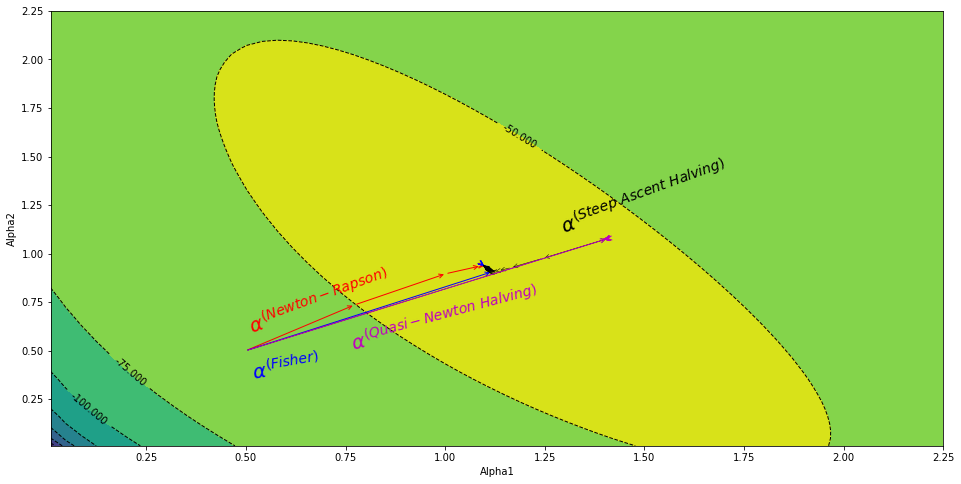

In [38]:
fig = plt.figure(figsize = (16,8))
newtonrapson = np.array(newtonrapson)
fisher=np.array(Fisher)
steepascenthalv=np.array(steepascenthalv)
quasinewtonhalv=np.array(quasinewtonhalv)

#all_ws2 = np.array(B2)
cp = plt.contour(Alpha1, Alpha2, loglike, colors='black', linestyles='dashed', linewidths=1)
plt.clabel(cp, inline=1, fontsize=10)
for i in range(len(newtonrapson) - 1):
    plt.annotate('', xy=newtonrapson[i + 1, :], xytext=newtonrapson[i, :],
                 arrowprops={'arrowstyle': '->', 'color': 'r', 'lw': 1},
                 va='center', ha='center')
for i in range(len(fisher) - 1):
    plt.annotate('', xy=fisher[i + 1, :], xytext=fisher[i, :],
                 arrowprops={'arrowstyle': '->', 'color': 'b', 'lw': 1},
                 va='center', ha='center')
for i in range(len(steepascenthalv) - 1):
    plt.annotate('', xy=steepascenthalv[i + 1, :], xytext=steepascenthalv[i, :],
                 arrowprops={'arrowstyle': '->', 'color': 'k', 'lw': 0.5},
                 va='center', ha='center')
for i in range(len(quasinewtonhalv) - 1):
    plt.annotate('', xy=quasinewtonhalv[i + 1, :], xytext=quasinewtonhalv[i, :],
                 arrowprops={'arrowstyle': '->', 'color': 'm', 'lw': 1},
                 va='center', ha='center')
plt.text(0.5, 0.75,
     r'$\alpha^{(Newton-Rapson)}$', verticalalignment='center',
     fontsize=20,color='red',rotation=20)
plt.text(0.6, 0.35,
     r'$\alpha^{(Fisher)}$', horizontalalignment='center',
     fontsize=20,color='b',rotation=10)
plt.text(1.5, 1.1,
     r'$\alpha^{(Steep\ Ascent\ Halving)}$', horizontalalignment='center',
     fontsize=20,color='k',rotation=20)
plt.text(1,0.5,
     r'$\alpha^{(Quasi-Newton\ Halving)}$', horizontalalignment='center',
     fontsize=20,color='m',rotation=15)
cp = plt.contourf(Alpha1, Alpha2, loglike, )
plt.xlabel('Alpha1')
plt.ylabel('Alpha2')
plt.show()